# Autoencoder MNIST Classifier

Reference: Advanced Deep Learning with TensorFlow 2 and Keras by Rowel Atienza, Chapter 3: Autoencoders

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Activation, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

import math
import matplotlib.pyplot as plt

In [2]:
# Load the MNIST data.
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Categorically encode the labels.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Reshape the data into the shape the network expects.
x_train = np.reshape(x_train, [-1, 28, 28, 1])
x_test = np.reshape(x_test, [-1, 28, 28, 1])

# Scale the data so that all values are in the [0, 1] interval.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [3]:
# Network parameters
latent_dim = 2

# Encoder
inputs = Input(shape=(28, 28, 1), name='encoder_input')
x = inputs

x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)

x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)

# Shape info needed to build decoder model
shape = x.shape.as_list()

# Generate a 16-dim latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# Instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()
#plot_model(encoder, to_file='classifier-encoder.png', show_shapes=True)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1849

In [4]:
print(shape[1])
print(shape[2])
print(shape[3])

7
7
64


In [5]:
# Decoder
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

x = Conv2DTranspose(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D()(x)

x = Conv2DTranspose(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D()(x)

x = Conv2DTranspose(filters=1, kernel_size=3, padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

# The decoder model takes in the latent layer and outputs the sigmoid layer.
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 64)          36928     
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 7, 7, 64)          36928     
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 64)          256 

![Neural Network](https://storage.googleapis.com/activation-function/images/jupyter/ae-classifier.svg)

<b>Figure 1.</b> Architecture of autoencoder as an image classifier

In [6]:
# Classifier Model
latent_inputs = Input(shape=(latent_dim,), name='classifier_input')
x = Dense(512)(latent_inputs)
x = Activation('relu')(x)
x = Dropout(0.4)(x)
x = Dense(256)(x)
x = Activation('relu')(x)
x = Dropout(0.4)(x)
x = Dense(10)(x)
classifier_outputs = Activation('softmax', name='classifier_output')(x)
classifier = Model(latent_inputs, classifier_outputs, name='classifier')
classifier.summary()

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
classifier_input (InputLayer [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1536      
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

We'll now put together a siamese network that outputs two things, a classifier and a decoder. They both take in the encoder model as input, but the layers that they add to the encoder are different. The classifier model adds dense layers and a final softmax layer, while the decoder model adds convolutional layers that are mirror opposite of the encoder convolutional layers.

Model: "autodecoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder (Functional)            (None, 2)            72034       encoder_input[0][0]              
                                                                 encoder_input[0][0]              
__________________________________________________________________________________________________
classifier (Functional)         (None, 10)           135434      encoder[0][0]                    
__________________________________________________________________________________________________
decoder (Functional)            (None, 28, 28, 1)    112033      encoder[1][0]          

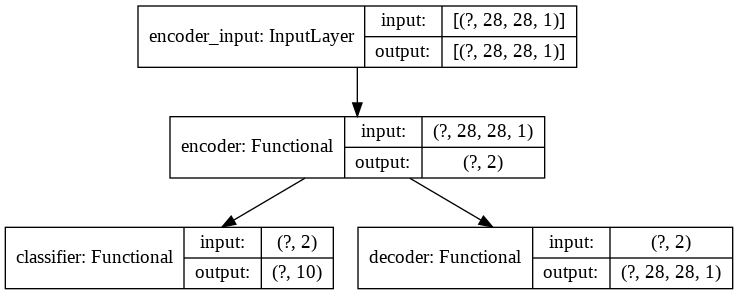

In [7]:
autoencoder = Model(inputs,
                    [classifier(encoder(inputs)), decoder(encoder(inputs))],
                    name='autodecoder')
autoencoder.summary()
plot_model(autoencoder, to_file='classifier-autoencoder.png', show_shapes=True)

In [8]:
# Loss function is categorical_crossentropy for the classifier.
# Loss function is mse for the decoder.
autoencoder.compile(loss=['categorical_crossentropy', 'mse'],
                    optimizer='adam',
                    metrics=['accuracy', 'mse'])

# Train the autoencoder for 3 epochs.
# y_train/y_test are the labels for the classifier output.
# x_train/x_test are the labels for the decoder output.
autoencoder.fit(x_train, [y_train, x_train],                
                validation_data=(x_test, [y_test, x_test]),
                epochs=3, batch_size=128)

Epoch 1/3
469/469 [==============================] - 7s 15ms/step - loss: 0.6587 - classifier_loss: 0.5903 - decoder_loss: 0.0684 - classifier_accuracy: 0.7909 - classifier_mse: 0.0281 - decoder_accuracy: 0.7825 - decoder_mse: 0.0684 - val_loss: 0.3421 - val_classifier_loss: 0.2869 - val_decoder_loss: 0.0552 - val_classifier_accuracy: 0.9086 - val_classifier_mse: 0.0133 - val_decoder_accuracy: 0.7964 - val_decoder_mse: 0.0552
Epoch 2/3
469/469 [==============================] - 7s 14ms/step - loss: 0.3309 - classifier_loss: 0.2769 - decoder_loss: 0.0540 - classifier_accuracy: 0.9125 - classifier_mse: 0.0128 - decoder_accuracy: 0.7944 - decoder_mse: 0.0540 - val_loss: 0.3142 - val_classifier_loss: 0.2609 - val_decoder_loss: 0.0533 - val_classifier_accuracy: 0.9148 - val_classifier_mse: 0.0124 - val_decoder_accuracy: 0.7941 - val_decoder_mse: 0.0533
Epoch 3/3
469/469 [==============================] - 6s 13ms/step - loss: 0.2642 - classifier_loss: 0.2112 - decoder_loss: 0.0530 - classifi

Get predictions from the autoencoder siamese network. y_hat is the prediction set of the classifier. x_decoded is the prediction set of the classifier.

In [9]:
y_hat, x_decoded = autoencoder.predict(x_test)
print('y_test:', np.argmax(y_test[:10], axis=1))
print('y_hat: ', np.argmax(y_hat[:10], axis=1))

y_test: [7 2 1 0 4 1 4 9 5 9]
y_hat:  [7 2 1 0 4 1 4 9 5 9]


10 out of 10 correct predictions. Very nice.

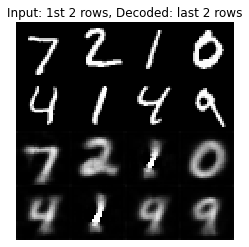

In [10]:
# Display the 1st 8 input and decoded images.
imgs = np.concatenate([x_test[:8], x_decoded[:8]])
imgs = imgs.reshape((4, 4, 28, 28))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('input_and_decoded.png')
plt.show()

The decoder outputted images that are very similar to the original x_test validation images. This slight similarity shows that some information was lost in the autoencoder's bottleneck layer.

In [20]:
latent = encoder.predict(x_test)
print(latent.shape)
print(latent[0])
print(np.argmax(y_test, axis=1).shape)

(10000, 2)
[10.538261 17.500576]
(10000,)


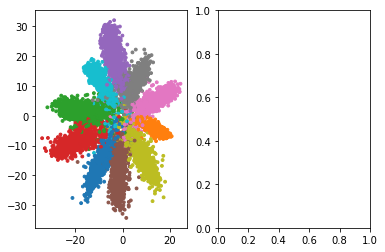

In [23]:
fig, ax = plt.subplots(1, 2)
ax[0].scatter(latent[:,0],latent[:,1],
	c=np.argmax(y_test, axis=1), s=8, cmap='tab10')